Hunter Bennett | Glass Lab | Kupffer Strains Project | May 03 2021  

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Clustered heatmap of differential peaks

In [61]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 500

# clustering packages
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [6]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [7]:
if not os.path.isdir('./h3k27ac_atac_differential_overlap/'):
    os.mkdir('./h3k27ac_atac_differential_overlap/')

### Import differential peaks

In [13]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    h3k27acDirectory+'/merged_peaks/diff_output.txt',
    h3k27acDirectory+'/merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (86301, 27)
getDiffExpression selected transcripts (84264, 36)
annotatePeaks selected peaks (84264, 27)


In [14]:
diff_peak_atac, peaks_atac, peak_mat_atac, peak_mat_quant_atac = import_homer_diffpeak(
    atacDirectory+'/merged_peaks/diff_output.txt',
    atacDirectory+'/merged_peaks/ann_norm_idr_peaks_merged.txt')

annotatePeaks all peaks (86301, 30)
getDiffExpression selected transcripts (84264, 39)
annotatePeaks selected peaks (84264, 30)


In [ ]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict_atac = pull_comparisons_get_diff(diff_peak_atac, seq_type='Peak')

In [46]:
color_dict = {'aj': ('#de2d26', '#a50f15'),
              'balbcj': ('#3182bd', '#08519c'),
              'c57bl6j': ('#31a354', '#006d2c')}

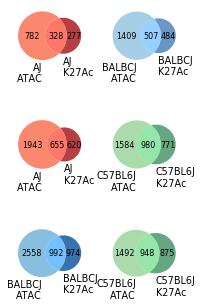

In [60]:
fig, axs = plt.subplots(3, 2, figsize=(3,6))
plt.subplots_adjust(hspace=0.0, wspace=.3)
for comp, ax in zip(comp_dict.keys(), [axs[0],axs[1],axs[2]]):
    up_strain = comp.split(' vs. ')[1]
    dn_strain = comp.split(' vs. ')[0]
    
    de_h3k27 = comp_dict[comp]
    de_atac = comp_dict_atac[comp]
    
    h3k27_up = de_h3k27.index[(((de_h3k27.adj_pval <= pval) & (de_h3k27.log2fc >= fc)) & (np.abs(de_h3k27.TSS_dist) >= 3000))].tolist()
    h3k27_dn = de_h3k27.index[(((de_h3k27.adj_pval <= pval) & (de_h3k27.log2fc <= -fc)) & (np.abs(de_h3k27.TSS_dist) >= 3000))].tolist()
    atac_up = de_atac.index[(((de_atac.adj_pval <= pval) & (de_atac.log2fc >= fc)) & (np.abs(de_atac.TSS_dist) >= 3000))].tolist()
    atac_dn = de_atac.index[(((de_atac.adj_pval <= pval) & (de_atac.log2fc <= -fc)) & (np.abs(de_atac.TSS_dist) >= 3000))].tolist()
    
    venn2([set(atac_dn), set(h3k27_dn)],
          set_labels=[dn_strain.upper()+'\nATAC',
                      dn_strain.upper()+'\nK27Ac'],
          set_colors=[color_dict[dn_strain][0],
                      color_dict[dn_strain][1]],
          alpha=0.8,
          ax=ax[0])
    
    venn2([set(atac_up), set(h3k27_up)],
          set_labels=[up_strain.upper()+'\nATAC',
                      up_strain.upper()+'\nK27Ac'],
          set_colors=[color_dict[up_strain][0],
                      color_dict[up_strain][1]],
          alpha=0.6,
          ax=ax[1])
    
plt.savefig('./h3k27ac_atac_differential_overlap/venn2_pairwise_overlap.pdf',
            bbox_inches='tight')

In [ ]:
for comp in comp_dict.keys():
    up_strain = comp.split(' vs. ')[1]
    dn_strain = comp.split(' vs. ')[0]
    
    de_h3k27 = comp_dict[comp]
    de_atac = comp_dict_atac[comp]
    
    h3k27_up = de_h3k27.index[(((de_h3k27.adj_pval <= pval) & (de_h3k27.log2fc >= fc)) & (np.abs(de_h3k27.TSS_dist) >= 3000))].tolist()
    h3k27_dn = de_h3k27.index[(((de_h3k27.adj_pval <= pval) & (de_h3k27.log2fc <= -fc)) & (np.abs(de_h3k27.TSS_dist) >= 3000))].tolist()
    atac_up = de_atac.index[(((de_atac.adj_pval <= pval) & (de_atac.log2fc >= fc)) & (np.abs(de_atac.TSS_dist) >= 3000))].tolist()
    atac_dn = de_atac.index[(((de_atac.adj_pval <= pval) & (de_atac.log2fc <= -fc)) & (np.abs(de_atac.TSS_dist) >= 3000))].tolist()
    
    print(comp)
    print('ATAC peaks up in %s: %i' % (dn_strain, len(set(atac_dn))))
    print('H3K27Ac peaks up in %s: %i' % (dn_strain, len(set(h3k27_dn))))
    print('N Shared: %i' % len( set(h3k27_dn).intersection(atac_dn) ))
    print('Total Peaks: %i' % len( set(h3k27_dn).union(atac_dn) ))
    print('Fraction Shared: %.2f' % (len(set(h3k27_dn).intersection(atac_dn)) / len(set(h3k27_dn).union(atac_dn))))
    print(' ')
    
    print('ATAC peaks up in %s: %i' % (up_strain, len(set(atac_up))))
    print('H3K27Ac peaks up in %s: %i' % (up_strain, len(set(h3k27_up))))
    print('N Shared: %i' % len( set(h3k27_up).intersection(atac_up) ))
    print('Total Peaks: %i' % len( set(h3k27_up).union(atac_up) ))
    print('Fraction Shared: %.2f' % (len(set(h3k27_up).intersection(atac_up)) / len(set(h3k27_up).union(atac_up))))
    print(' ')